In [408]:
import pickle
import os
from nltk import everygrams
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.sparse import vstack, hstack, csr_matrix
import numpy as np

import warnings

warnings.filterwarnings("ignore")

In [ ]:
caminho = os.path.dirname(os.path.realpath('')) + '\\models\\'
caminho

In [410]:

class isitkbs(object):
    
    def __init__(self, model='randomforest'):
        self.model = model
    # Especifica qual modelo deve ser utilizado
    # Por padrão, usa-se o randomForest

    # Função para determinar se uma palavra é keyboardsmashing
    # A entrada deve ser uma palavra
    def wordkbs(self, input_data):
        if not isinstance(input_data, str):
            raise TypeError("input_data must be a string")
        
        if aux._is_kbs_manual(string=input_data):
            return 1

        
        
        modelpath = os.path.join(caminho, f'{self.model}.pkl')
        vectpath = os.path.join(caminho, f'{self.model}_count_vectorizer.pkl')
        selpath = os.path.join(caminho, 'rf_selectkbest.pkl')
        #modelpath = os.path.join(os.path.dirname(os.path.dirname(__file__)), f'models/{self.model}.pkl')
        #vectpath = os.path.join(os.path.dirname(os.path.dirname(__file__)), f'models/{self.model}_count_vectorizer.pkl')
        #selpath = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'models/rf_selectkbest.pkl')

        trained_model = pickle.load(open(modelpath, 'rb'))
        vectorizer = pickle.load(open(vectpath, 'rb'))
        selector = pickle.load(open(selpath, 'rb'))

        if (len(input_data) == 1):
            return 0

        input_ngram_features = vectorizer.transform([input_data])
        if self.model == 'randomforest':
            input_ngram_features = selector.transform(input_ngram_features)
        # Extract lexical features for the new string
        input_vowel_feature = csr_matrix(np.array(aux.type_ratio(input_data, 'v')).reshape(-1,1))
        input_consonant_feature = csr_matrix(np.array(aux.type_ratio(input_data, 'c')).reshape(-1,1))
        input_ttr_feature = csr_matrix(np.array(aux.ttr(input_data)).reshape(-1,1))

        # Combine the N-gram and lexical features into a single feature matrix
        input_lexical_features = hstack((input_vowel_feature, input_consonant_feature, input_ttr_feature))
        input_features = hstack((input_lexical_features, input_ngram_features))

        # Make the prediction using the trained model
        pred = trained_model.predict(input_features)
        predprob = trained_model.predict_proba(input_features)
        #print(f"{pred}:{predprob}")
        return pred[0]

    # Função para determinar quais são os keyboard smashing em uma frase
    # A entrada deve ser uma string ou uma lista de palavras
    def sentkbs(self, input_data):
        mashs = []
        
        if isinstance(input_data, str):
            words = input_data.split()
        elif isinstance(input_data, list):
            words = input_data
        else:
            return mashs

        for word in words:
            if isinstance(word, str):
                if ' ' in word:
                    mashs_partial = self.sentkbs(word)
                    mashs.extend(mashs_partial)
                else:
                    res = self.wordkbs(word)
                    if res == 1:
                        mashs.append(word)
        
        return mashs

    # Função que mostra a frequência de caracteres em keyboard smashing
    # A entrada deve ser uma string ou uma lista de string
    def freqkbs(self, input_data, graph=False):
        char_counts = {}
        #cleaned_data = self.sentkbs(' '.join(self.sentkbs(input_data)))
        cleaned_data = ' '.join(self.sentkbs(input_data))
        if cleaned_data:
            cleaned_data = re.sub(r'[^\w\s]', '', cleaned_data)
            for char in set(cleaned_data):
                char_counts[char] = cleaned_data.count(char)
            char_counts = dict(sorted(char_counts.items()))
            char_counts.pop(' ', None)
            if graph:
                self.__freqgraph(char_counts)
        return char_counts

    def __freqgraph(self, cont_char):
        # Determina eixo x e eixo y
        x_axis = list(cont_char.keys())
        y_axis = list(cont_char.values())

        # Nomeia os eixos
        plt.xlabel('Caracteres')
        plt.ylabel('Freq')

        # Plota o gráfico
        plt.bar(x_axis, y_axis)

    def replacekbs(self, input_data, value=None, inplace=False, just_word=False):
        """ 
        Parâmetros:
        dataframe: dataframe pandas do qual os keyboard smashing vão ser substituidos.
        value: string que vai substituir os keyboard smashings, caso seja uma string vazia as linhas que apresentarem kbs serão removidas do dataframe
        inplace: se as substituições serão feitas no próprio dataframe dos parâmetros (True) ou será retornada uma cópia do df (False)
        just_word: se False, a posição toda do dataframe é substituído por value, se True somente o kbs presente na posição é substituido
        Ex: "This isdas test" -> "KBS" (just_word False)
                              -> "This KBS test" (just_word True)
        """
        value = value or "itskbs"
        
        """ 
        Se o tipo de entrada for um dataframe pandas, a função __dataframe é chamada para fazer o tratamento
        """
        if isinstance(input_data, pd.DataFrame):
            df = input_data.copy(deep=False) if inplace else input_data.copy()
            return self.__dataframe(df, value, just_word)

        """ 
        Se o tipo de entrada for uma lista ou uma string de palavras, a função __listOrString é chamada
        """
        if isinstance(input_data, str) or isinstance(input_data, list):
            return self.__listOrString(input_data, value, just_word)

    def __dataframe(self, df, value, just_word):
        wordskbs = []
        nRow = df.shape[0]
        nCol = df.shape[1]
        mashsIndex = []
        for row in range(nRow):
            for col in range(nCol):
                wordskbs = self.sentkbs(df.iloc[row, col])
                if (len(wordskbs) != 0):
                    if (just_word == False):
                        if(value == 'itskbs'):
                            mashsIndex.append(row)
                        else:
                            df.iloc[row, col] = value
                    else:
                        df.iloc[row, col] = self.replacekbs(
                            df.iloc[row, col], value)
        df.drop(mashsIndex, axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df
    
    """ def __listOrString(self, input_data, value, just_word):
        is_list = True
        if type(input_data) != list:
            is_list = False
            input_data = input_data.split()
        
        wordskbs = self.sentkbs(input_data)
    
        if value == 'itskbs':
            output_data = [
                i for i in input_data if i not in wordskbs
            ]
        else:
            output_data = [
                value if i in wordskbs else i for i in input_data
            ]
        return ' '.join(output_data) if not is_list else output_data """
        
    def __listOrString(self, input_data, value='itskbs', just_word=False):
        is_list = True
        if type(input_data) == str:
            input_data = input_data.split()
            is_list = False
        
        wordskbs = self.sentkbs(input_data)
        output_data = []
        for i in input_data:
            if ' ' in i:
                sent = self.__listOrString(i, value, just_word)
                if just_word:
                    output_data.append(sent)
                    continue
                elif sent != i:
                    output_data.append(value)
                    continue
            if value == 'itskbs':
                if i not in wordskbs:
                    output_data.append(i)
            else:
                output_data.append(value if i in wordskbs else i)
        return ' '.join(output_data) if not is_list else output_data
    


class aux(object):

    # Funções auxiliares
    @classmethod
    def letter_counter(cls, string, type=None):
        if (type == 'c'):
            return {letter: str(string).count(letter) for letter in 'bcdfghjklmnpqrstvwxyz'}
        elif (type == 'v'):
            return {letter: str(string).count(letter) for letter in 'aeiou'}  
        return {letter: str(string).count(letter) for letter in 'abcdefghijklmnopqrstuvwxyz'}

    @classmethod
    def type_counter(cls, string, type=None):    
        return sum(cls.letter_counter(string, type).values())
    
    @classmethod
    def type_ratio(cls, string, type=None):
        if (len(string) == 0):
            return 0
        return cls.type_counter(string, type)/len(string)

    @classmethod
    def bigram_counter(cls, lista):
        dic = {}
        for i in lista:
            if i in dic:
                dic[i] +=1
            else:
                dic[i] =1
        return dic

    @classmethod
    def bigrams(cls, string):
        bigrams = []
        for i in range(len(string)-1):
            bigrams.append(string[i]+string[i+1])

        return cls.bigram_counter(bigrams)

    @classmethod
    def bigram_max_occurance(cls, string):
        try:
            return (sorted(cls.bigrams(string).values(), reverse=True))[0]
        except:
            return 0
        
    @classmethod
    def ttr(cls, string):
        if (len(string) == 0):
            return 0
        ttr = len(set(string)) / len(string)
        return ttr


    def __bigramas_proibidos(self, string):
        proibidos = ['zx', 'xj', 'wx', 'vx', 'vq', 'vj', 'vf', 'sx', 'qz', 'qx', 'qk', 'qj', 'qc', 'jz', 'jx', 'jq', 'jf', 'hx', 'gx', 'fq', 'bx', 
                     'cv', 'cx', 'dx', 'fv', 'fx', 'fz', 'gv', 'jg', 'jk', 'jl', 'jm', 'jt', 'jv', 'jw', 'kq', 'kx', 'kz', 'pq', 'px', 'qd', 'qe', 
                     'qf', 'qg', 'qh', 'ql', 'qm', 'qn', 'qo', 'qp', 'qr', 'qs', 'qv', 'qw', 'qy', 'vb', 'vm', 'vp', 'vw', 'vz', 'xz', 'zj']

        bigramas = self.bigrams(string)

        for bigrama in bigramas:
            if bigrama in proibidos:
                return 1
        return 0   
    
    def __repeticao_de_bigramas(self, string, len):
        max_o = self.bigram_max_occurance(string)
        if (max_o == 4 and len < 12) or max_o > 4:
            return True 
        return False

    
    # Resultado
    @classmethod
    def _is_kbs_manual(cls, string):
        try:    
            length = len(string)
            
            if cls.__repeticao_de_bigramas(cls, string, length): return 1
            if cls.__bigramas_proibidos(cls, string): return 1
        except:
            return 0

In [411]:
teste = isitkbs()

In [412]:
teste.replacekbs("I asdsaxxxxdas Sidney", 'am')

'I am Sidney'

In [413]:
teste.replacekbs("I asdxxxxsadas Sidney")

'I Sidney'

In [414]:
teste.replacekbs(["I asdsadas Sidney"], 'am', just_word=True)

['I am Sidney']

In [415]:
teste.replacekbs(['Hello', 'aassxxx', 'Try'], 'Vasco')

['Hello', 'Vasco', 'Try']

{'a': 3, 'c': 2, 'd': 1, 's': 3, 'x': 7}

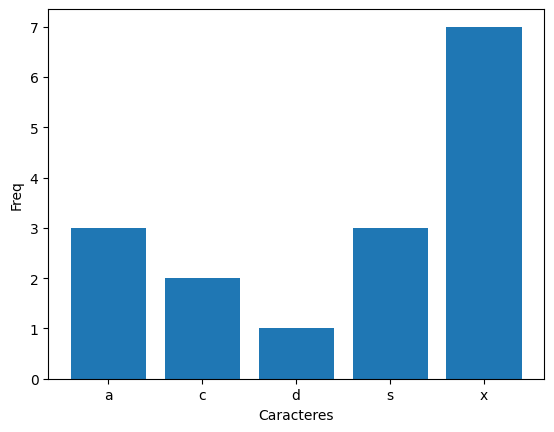

In [416]:
teste.freqkbs("axxxxxasassdxxcc", graph=1)

In [417]:
palavras = {"data": ["Douglas is a  xxassds", "xxuszx friend", 54, "thought", "interesting", "kjadlsjda", "world", "aaaaaaa",
                     "vessel"], "data2": ["none", "name", "aklksda", "zzzzzz", "exception", "optional", "bottle", "piooijoj", "mnfjisdh"]}
df = pd.DataFrame(palavras)
df

,data,data2
0,Douglas is a xxassds,none
1,xxuszx friend,name
2,54,aklksda
3,thought,zzzzzz
4,interesting,exception
5,kjadlsjda,optional
6,world,bottle
7,aaaaaaa,piooijoj
8,vessel,mnfjisdh


In [419]:
# Substituir somente o kbs encontrado pela palavra APAGAR

df2 = teste.replacekbs(df, 'APAGAR', just_word=True)

display(df2)

,data,data2
0,Douglas is a APAGAR,none
1,APAGAR friend,name
2,54,APAGAR
3,thought,APAGAR
4,interesting,exception
5,APAGAR,optional
6,world,bottle
7,APAGAR,APAGAR
8,vessel,APAGAR


In [421]:
df3 = teste.replacekbs(df, just_word=True)

df3

,data,data2
0,Douglas is a,none
1,friend,name
2,54,
3,thought,
4,interesting,exception
5,,optional
6,world,bottle
7,,
8,vessel,


In [423]:
df4 = teste.replacekbs(df, 'ACHEI')

df4

,data,data2
0,ACHEI,none
1,ACHEI,name
2,54,ACHEI
3,thought,ACHEI
4,interesting,exception
5,ACHEI,optional
6,world,bottle
7,ACHEI,ACHEI
8,vessel,ACHEI


In [424]:
# Apagar toda a linha que tenha um KBS (onde está itskbs)

df5 = teste.replacekbs(df)

df5

,data,data2
0,interesting,exception
1,world,bottle
